# Introduction and Data Cleaning

My aim is to predict customer churn for [Brass Business Bank (Brass)](https://www.trybrass.com/about/), a B2B company - founded in Nigeria [less than three years ago](https://brassbanking.medium.com/introducing-brass-banking-nigerias-local-businesses-143c0ccf2bb8) - offering commerical-grade current accounts, financial products, education, financing and partnership to support its clients which are all businesses. 

Brass provided me with two anonymized and unfiltered datasets (I have provided those two datasets in the data folder of this project):
1. A [transactions.csv](http://localhost:8917/lab/tree/data/transactions.csv) file which contained more than 700k rows of transactions over the course of the year 2022. 
2. A [customers.csv](http://localhost:8917/lab/tree/data/customers.csv) file which contained information for a sample of almost 8k customers.

On the surface this looks like a massive amount of data. However, because the two datasets had not been filtered, there were lots of customers in the `customers` sample without any transaction in the `transactions` sample. And there were rows of transactions in the `transactions` sample that were carried out by customers who were not in the `customers` sample. I had to filter only those customers in the `customers` sample who had transactions recorded in the `transactions` sample.

To do this, I used SQL (from BigQuery) to join the two datasets together on their respective `ID` columns using the code below:
> SELECT *

>FROM `capstone-378117.customers.customers`AS c

>JOIN `capstone-378117.transactions.transactions` AS t

>ON c.ID = t.Accounts_____Customer_ID 

This massively reduced the number of transactions from more than 700_000 to approximately 300_000. Even more significantly, it reduced the number of unique customers from almost 8_000 to roughly 1_500 unique customers. Similarly, as you would see below, the joined dataset does not contain a lot of features as I would have ideally preferred due to the bank's security-based reservations about sharing more details. Thus, I would have to rely heavily on engineering a new set of features in this project. 

In [1]:
#First our imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Reading in the joined dataset
brass = pd.read_csv('./data/brass.csv') 

In [2]:
#Check the first 7 rows
brass.head(7)

,ID,Customer_Types_____Display_Name,Industries_____Name,Type,Amount,Ledger_Balance,Available_Balance,Commit_At,Accounts_____Customer_ID
0,6144,Limited Liability,General Services,debit,3700000,7000000,3300000,2022-01-19 12:16:38 UTC,6144
1,6144,Limited Liability,General Services,debit,2688,7000000,3300000,2022-01-19 12:16:38 UTC,6144
2,6144,Limited Liability,General Services,debit,1000000,18297312,17297312,2022-01-25 09:37:59 UTC,6144
3,6144,Limited Liability,General Services,debit,2688,18297312,17297312,2022-01-25 09:37:59 UTC,6144
4,6144,Limited Liability,General Services,debit,3700000,17294624,13594624,2022-01-25 11:41:54 UTC,6144
5,6144,Limited Liability,General Services,debit,2688,17294624,13594624,2022-01-25 11:41:54 UTC,6144
6,6144,Limited Liability,General Services,debit,18150000,38591936,20441936,2022-01-25 15:55:36 UTC,6144


# Data Cleaning

1. Since the `ID` and `Accounts_____Customer_ID` columns for each row are the same, I will drop the latter. 

2. I will also rename the columns for the sake of convenience and readability. 

3. I will convert the column displaying dates to a `date_time` column.

## Dropping and Renaming Columns

In [3]:
#Drop `Accounts_____Customer_ID` column
brass.drop(columns=['Accounts_____Customer_ID'], inplace=True)
brass.head(1)

,ID,Customer_Types_____Display_Name,Industries_____Name,Type,Amount,Ledger_Balance,Available_Balance,Commit_At
0,6144,Limited Liability,General Services,debit,3700000,7000000,3300000,2022-01-19 12:16:38 UTC


In [4]:
#Rename columns
brass.rename(columns = {'ID': 'id', 
              'Customer_Types_____Display_Name': 'registration_type', 
              'Industries_____Name': 'industry', 
              'Type': 'transaction_type', 
              'Amount': 'amount',
             'Ledger_Balance': 'ledger_balance',
             'Available_Balance': 'available_balance',
             'Commit_At': 'date'}, inplace=True)

brass.head(1)

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date
0,6144,Limited Liability,General Services,debit,3700000,7000000,3300000,2022-01-19 12:16:38 UTC


In [5]:
#Convert the date column to datetime

brass['date'] = pd.to_datetime(brass['date']).dt.date
brass['date'] = pd.to_datetime(brass['date']).dt.normalize() #using dt.normalize() in order to drop the time component while leaving as datetime64 dtype
brass.info()
brass.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298902 entries, 0 to 298901
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 298902 non-null  int64         
 1   registration_type  298902 non-null  object        
 2   industry           298902 non-null  object        
 3   transaction_type   298902 non-null  object        
 4   amount             298902 non-null  int64         
 5   ledger_balance     298902 non-null  int64         
 6   available_balance  298902 non-null  int64         
 7   date               298902 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 18.2+ MB


,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date
0,6144,Limited Liability,General Services,debit,3700000,7000000,3300000,2022-01-19


## Overview of the joined dataset

In [6]:
#Creating function to further peruse the data

def details(df, header):
    '''
    This function takes in the name of the dataframe and a header.
    Prints out the number of rows, number of features/columns, number
    of null values (if any), datatypes of the different columns,
    and the number of unique values in each column.
    '''
    print(f'Number of rows: {df.shape[0]}')
    print(f'\nNumber of features: {df.shape[1]}')
    print(f'\nAre there any null values? {df.isnull().sum().values.sum()}')
    print(f'\nDatatypes of the features: ')
    print(df.dtypes)
    print("\nNumber of unique values in each feature:")
    print(df.nunique())
    
#Apply the function to our brass dataframe
details(brass, 'Overview of Brass Dataset:')    

Number of rows: 298902

Number of features: 8

Are there any null values? 0

Datatypes of the features: 
id                            int64
registration_type            object
industry                     object
transaction_type             object
amount                        int64
ledger_balance                int64
available_balance             int64
date                 datetime64[ns]
dtype: object

Number of unique values in each feature:
id                     1493
registration_type         6
industry                 26
transaction_type          2
amount                50278
ledger_balance       154225
available_balance    188416
date                    361
dtype: int64


## Observations
- **About 1500 customers**: Our `id` column which represents the number of unique customers in our dataset contains 1493 unique values. Although our dataset contains almost 300_000 rows, the rows represent transactions carried out by just about 1_500 customers.

- **Almost every day in 2022 represented**: We have transactions recorded for 361 out of 365 days in the year 2022. 

- **Limited features for segmentation**: We have a lot of features that provide information about a customer's transactions and balances, but we do not have a lot of features that provide information about the customers themselves. Only the `registration type` and `industry` provide additional details about the customers. This limits us somewhat as it becomes harder to segment the customers based on certain demographics. As a result we will rely on a lot of feature engineering in this project to predict churn. 

- **No churn feature**: There is no column in the data representing churn. That is something we would have to derive/discover for ourselves based on the transaction data provided. 

# Data Dictionary
|**S/No**|**Feature**|**Type**|**Description**|
|:---|:---|:---|:---|
|1|`id`|int64|Unique ID for each customer in the dataset|
|2|`registration_type`|object|Type of business entity based on registration of the customer|
|3|`industry`|object|Industry type for customer's business|
|4|`transaction_type`|object|One of either debit or credit transaction|
|5|`amount`|int64|Amount debited or credited per transaction. `amount` is in **kobos.** This is Nigerian currency. **100 kobos = 1 Naira**. This is similar to how 100 cents = 1 US dollar|
|6|`ledger_balance`|int64|Balance in the account at the end of the business day and starting balance at the beginning of the next business day. `ledger_balance` is in **kobos.** This is Nigerian currency. **100 kobos = 1 Naira**. This is similar to how 100 cents = 1 US dollar|
|7|`available_balance`|int64|Amount available for withdrawal at a given moment. `available_balance` is in **kobos.** This is Nigerian currency. **100 kobos = 1 Naira**. This is similar to how 100 cents = 1 US dollar|
|8|`date`|datetime|Date of transaction. All dates are in 2022, ranging from `2022-01-04` to `2022-12-31`| 

## Converting kobos into Naira in the three monetary columns
As explained in the data dictionary, `Naira` and `kobo` are the names of Nigeria's currency. They are akin to the US dollars and cents, their conversion is the same, with 100 kobo = 1 Naira. Below I convert kobo into Naira by dividing by 100. 

In [7]:
#The monetary columns are amount, ledger_balance and available_balance
brass['amount'] = [round(k/100, 2) for k in brass['amount']]  #rounding to two decimal places so that the kobo component remains
brass['ledger_balance'] = [round(k/100, 2) for k in brass['ledger_balance']]
brass['available_balance'] = [round(k/100,2) for k in brass['available_balance']] 

In [8]:
#checking the columns
brass.head(3)

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date
0,6144,Limited Liability,General Services,debit,37000.00,70000.00,33000.00,2022-01-19
1,6144,Limited Liability,General Services,debit,26.88,70000.00,33000.00,2022-01-19
2,6144,Limited Liability,General Services,debit,10000.00,182973.12,172973.12,2022-01-25


In [9]:
brass.tail(3)

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date
298899,46591,Limited Liability,Digital Services,credit,3000000.00,829428.21,697374.46,2022-12-23
298900,46591,Limited Liability,Digital Services,credit,225000.00,341675.70,341675.70,2022-12-23
298901,46591,Limited Liability,Digital Services,credit,53.75,566675.70,566675.70,2022-12-23


# Defining and Calculating churn

In conversations with the Brass team, I discovered that Brass does not currently have a defined method of calculating churn. So I have to make the call on how to define churn for the purposes of this project. Initially, my instinct was to set a brute time frame of 90 days above which any customer whose acount has not had any transactions would be classified as 'churn'. However, it makes sense to first take a closer look at the distribution of the data and how often transactions happen in customers' Brass accounts before deciding on a cutoff.

Below, I will calculate the time difference between the first day of 2023 and the last time there was a transaction in an account. 

NB: Our data stops on the last day of 2022, but for some future calculations i want to avoid a value of 0. By using 2023-01-01, it ensures that every value would be at least 1.

Steps:
1. Sort dataframe 

2. Create a `difference` column which calculates difference between 2023-01-01 and the `brass['date']` value for each row. 

3. Group the dataframe by the `id` column and aggregate by the minimum value for the `difference` column. This represents the latest transaction for each unique id.

4. Examine that column.

In [11]:
#sort the brass dataframe according to id and date
brass = brass.sort_values(by=['id', 'date'])

#create a column called `difference` which is number of days between each transaction and year end 
brass['difference'] = pd.to_datetime('2023-01-01') - brass['date']

#Grouping by `id` and aggregating. Renaming this grouped dataframe as `min_diff`
min_diff = brass.groupby('id').min()

#Checking top 10 rows in grouped dataframe
min_diff.head(10)

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference
id,,,,,,,,
21,Enterprise,General Services,credit,100.00,0.00,0.00,2022-07-16,168 days
122,Limited Liability,Technology,credit,12000.00,0.00,0.00,2022-04-15,261 days
159,Sole Proprietorship,Technology,credit,26.88,0.00,0.00,2022-05-05,11 days
217,Limited Liability,Digital Services,credit,12000.00,0.00,0.00,2022-05-26,220 days
323,Sole Proprietorship,Others,credit,3.00,0.00,0.00,2022-04-27,16 days
373,Limited Liability,E-Commerce,credit,10.75,0.00,0.00,2022-03-29,11 days
498,Limited Liability,Technology,credit,10.75,0.00,0.00,2022-12-09,2 days
686,Sole Proprietorship,E-Commerce,credit,26.88,0.00,0.00,2022-10-09,3 days
1108,Sole Proprietorship,Press & Media,credit,10.75,1.19,1.19,2022-01-04,3 days


In [12]:
#Examining this new column

print(min_diff['difference'].mean()) #The mean difference between end of year and the most recent transactions per customer

print(min_diff['difference'].median()) #The median difference between end of year and the most recent transactions per customer

print(min_diff['difference'].quantile(0.75)) #The 75th percentile of the diff column

min_diff.dtypes #The difference column has a timedelta datatype

107 days 20:29:44.326858674
92 days 00:00:00
184 days 00:00:00


registration_type             object
industry                      object
transaction_type              object
amount                       float64
ledger_balance               float64
available_balance            float64
date                  datetime64[ns]
difference           timedelta64[ns]
dtype: object

In [13]:
#I will calculate these same stats for the brass dataframe which contains alll the data, not just the grouped minimum
print(brass['difference'].mean()) 

print(brass['difference'].median())

print(brass['difference'].quantile(0.75))

124 days 07:44:05.819700100
116 days 00:00:00
183 days 00:00:00


# What does this tell me?

On average, Brass accounts can lay dormant for long periods between transactions. They are clearly not accounts that the businesses use day-to-day. This is something that the Brass team has to be mindful of because if customers can easily go months without the need to use their Brass accounts, then churning becomes easy.

Now let's consider the values we got in the two dataframes for the mean, median and 75th percentiles.

|What|Grouped dataframe `min_diff`|General dataframe `brass`|
|---|---|---|
|Mean time between most recent transactions per customer and year end|107 days|124 days|
|Median time between most recent transactions per customer and year end|92 days|116 days|
|**75th percentile**|**184 days**|**183 days**|

It is clear that no matter which dataframe we look at, for 75% of the time, the difference between the transactions in 2022 and the end of the year was below 184 days(or 183 days). In my opinion, it makes more sense to use this 75th percentile rather than any of those averages as the cutoff for churn. Hence, 184 days would be my cutoff for churn. Accounts without transactions in over 184 days would be considered to have churned. 

# Converting timedelta object to integer
I would like to convert the `difference` column from a timedelta dtype to an integer. This will remove the 'days' string and make it easier to manipulate.

In [14]:
brass['difference'] = brass['difference'].dt.days
min_diff['difference'] = min_diff['difference'].dt.days

In [15]:
min_diff.head(2) #displaying as expected

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference
id,,,,,,,,
21,Enterprise,General Services,credit,100.0,0.0,0.0,2022-07-16,168
122,Limited Liability,Technology,credit,12000.0,0.0,0.0,2022-04-15,261


The plot of the distribution of the differences below shows a right skew and also shows that some transactions happen in accounts even later than the 183 days cutoff I have chosen. However an investigation of those transactions show that they are often small negligible amounts. 

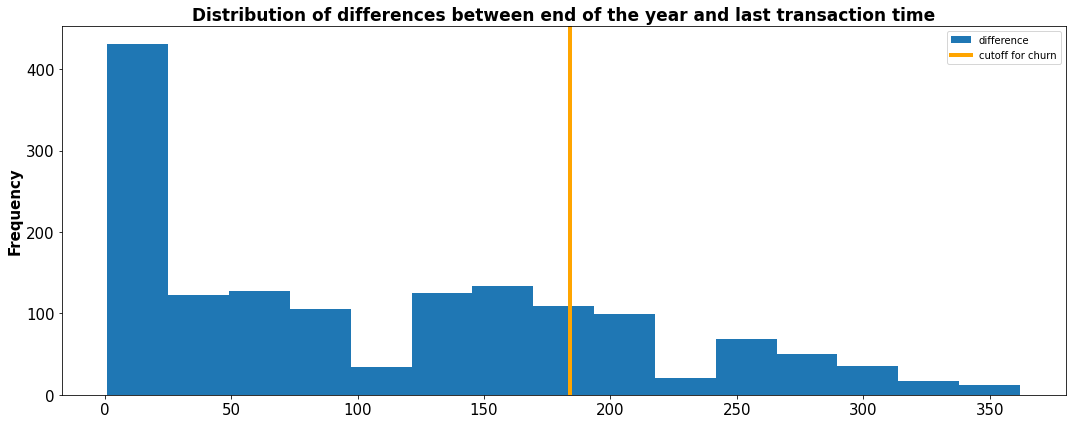

In [16]:
#sns.set_theme(style='ticks', context='talk')

min_diff['difference'].plot(kind='hist', bins=15, figsize=(15,6))
top_quarter = min_diff['difference'].quantile(0.75)
plt.title('Distribution of differences between end of the year and last transaction time', fontsize=17, fontweight='bold')
plt.axvline(x = top_quarter, color='orange', label='cutoff for churn', linewidth=4)
plt.tick_params(axis='both', labelsize=15)
plt.ylabel('Frequency', size=15, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('./images/distribution_of_difference.png', dpi=300);

# Creating a churn column

In the `min_diff` dataframe, I'll create a new column called `churn`. If the `difference` column has an integer value greater than 184, then this new `difference` column would contain the string - `churn`. Otherwise, it would contain `not churn`. 

In [17]:
#Creating `churn` column
min_diff['churn'] = ['churn' if x>184 else 'not churn' for x in min_diff['difference']]

In [18]:
min_diff.head(2) #displaying as expected

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
id,,,,,,,,,
21,Enterprise,General Services,credit,100.0,0.0,0.0,2022-07-16,168,not churn
122,Limited Liability,Technology,credit,12000.0,0.0,0.0,2022-04-15,261,churn


In [19]:
#Below we see that our dataset is unbalanced, with the 'not churn' class having a higher proportion compared to the 'churn' class.
#79% vs 21%

min_diff['churn'].value_counts(normalize=True)

not churn    0.789685
churn        0.210315
Name: churn, dtype: float64

# Null accuracy

As seen above, our data contains imbalanced classes. This is a binary classification problem with the positive class (churn) having a proportion of 21% while the negative class (not churn) has a proportion of 79%. Hence, our null accuracy - which is the proportion of the majority class - is 79%. This means that if we were to guess every single time that a customer has not churned, we would be right 79% of the time. 

With that in mind, it would not make much sense to rely exclusively on accuracy as the metric of choice for the evaluation of our model.

For this problem, we would consider five evaluation metrics:
- **Accuracy score**: Inclusion of accuracy score here is mainly just because it is customary practice. But for an inbalanced dataset, the accuracy score can be misleading and practically useless. 
- **Balanced accuracy score**: Balanced accuracy takes the average of sensitivity and specificity. In terms of accuracy scores, this is preferable to the traditional accuracy score as it measures the average accuracy obtained from the majority and minority classes. If the model performs just as well for both churn and not churn, then balanced accuracy would be same as accuracy score. However if model just taking advantage of the positive class(not churn), then balanced accuracy drops.
- **Recall/Sensitivity**: This is an important metric for us because recall minimizes the false negatives, which is absolutely what we want here. Brass can afford false positives (i.e. when model says a customer is churning when the customer isn't.) Worst case there is to make oureaches to such a customer and there's no harm in that. However if the model says a customer is not churning when the customer is in fact chrning, then Brass would lose such a customer - which is the opposite of what we want. 
- **Geometric mean**: The geometric mean measures the balance between the classification performances in both the positive(churn) and negative(not churn) classes. It is the square root of (sensitivity * specificity), and would be low if the model does great at classifying the negative classes but performs poorly with the positive classes.
- **Fbeta score**: The Fbeta score is calculated using precision and recall. It is related to the F1-score which is the harmonic mean between precision and recall. However, whereas the F1-score gives equal weighting to both precision and recall, the Fbeta score has a beta parameter that can be adjusted to give a bigger weight to one or the other. In our case we would weigh the recall more by giving the beta a value of 1.5. 

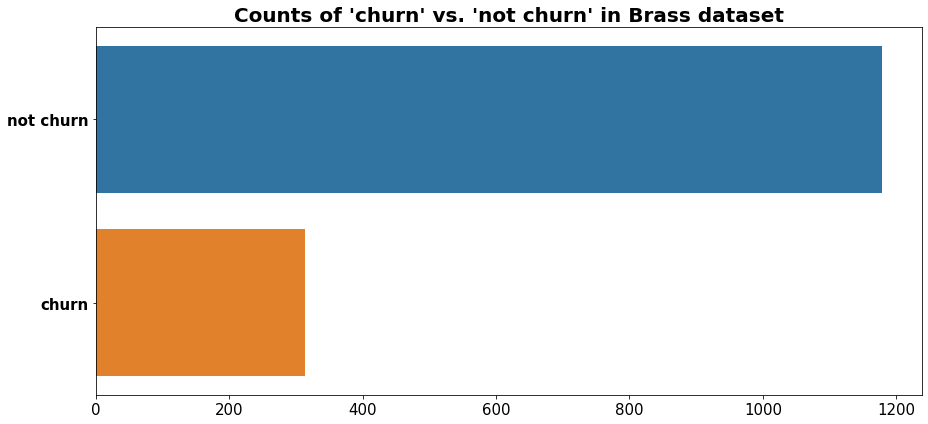

In [20]:
#Plotting the count of our two classes

#sns.set_theme(rc={'figure.figsize': (20,6)}, style='ticks', context='talk')

plt.figure(figsize=(13,6))
s = min_diff.churn.value_counts()
sns.barplot(x = s.values, y=s.index)
plt.title("Counts of 'churn' vs. 'not churn' in Brass dataset", {'fontsize':20, 'color': 'black', 'fontweight': 'bold'})
plt.xticks(size=15)
plt.yticks(size=15, fontweight='bold')
plt.tight_layout()
plt.savefig('./images/churn_v_notchurn.png', dpi=300);

# Mapping churn column
For easier manipulation I'll map the churn column with 0 and 1 representing non-churn and churn respectively.

In [21]:
min_diff['churn'] = min_diff['churn'].map({'not churn': 0, 'churn': 1})

In [22]:
min_diff.head()

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
id,,,,,,,,,
21,Enterprise,General Services,credit,100.00,0.0,0.0,2022-07-16,168,0
122,Limited Liability,Technology,credit,12000.00,0.0,0.0,2022-04-15,261,1
159,Sole Proprietorship,Technology,credit,26.88,0.0,0.0,2022-05-05,11,0
217,Limited Liability,Digital Services,credit,12000.00,0.0,0.0,2022-05-26,220,1
323,Sole Proprietorship,Others,credit,3.00,0.0,0.0,2022-04-27,16,0


In [23]:
brass.head()

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference
221964,21,Enterprise,General Services,credit,100.0,0.0,0.0,2022-07-16,169
50464,21,Enterprise,General Services,debit,100.0,100.0,0.0,2022-07-17,168
100151,122,Limited Liability,Technology,debit,12000.0,20000.0,20000.0,2022-04-15,261
241799,122,Limited Liability,Technology,credit,20000.0,0.0,0.0,2022-04-15,261
116900,159,Sole Proprietorship,Technology,debit,12000.0,12000.0,12000.0,2022-05-05,241


# Merging `brass` dataframe with `min_diff['churn']` column

Recall that we have been working alternatively with two different dataframes.
1. The `brass` dataframe - our original df which contains a single transaction on each row. 

2. The `min_diff` dataframe - an aggregated dataframe which we used in deriving the most recent date of transaction grouped by the unique id's, and from which we then determined if a given id has churned or not. This `min_diff` contains the `churn` column. 

Below, I merge that `churn` column with the `brass` dataframe using the `id` column as their common key. 

In [24]:
brass = brass.merge(min_diff['churn'], on='id')

In [25]:
brass.head()

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
0,21,Enterprise,General Services,credit,100.0,0.0,0.0,2022-07-16,169,0
1,21,Enterprise,General Services,debit,100.0,100.0,0.0,2022-07-17,168,0
2,122,Limited Liability,Technology,debit,12000.0,20000.0,20000.0,2022-04-15,261,1
3,122,Limited Liability,Technology,credit,20000.0,0.0,0.0,2022-04-15,261,1
4,159,Sole Proprietorship,Technology,debit,12000.0,12000.0,12000.0,2022-05-05,241,0


# Exporting dataframes

In [32]:
brass.to_csv('./data/brass_churn.csv', index=False) #saving the brass dataframe which now has the churn column
min_diff.to_csv('./data/min_diff.csv') #saving the min_diff as well as I intend to use in next notebook